In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro.distributions as dist
import pyro.optim
from pyro.nn import AutoRegressiveNN
from pyro.distributions import TransformedDistribution
from pyro.distributions.transforms import AffineAutoregressive, ComposeTransform
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/home/pgrad2/2448355h/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Using device: cuda


In [2]:
def sim_revexp_u_mgpd(n, d, a, beta, sig, gamma, MGPD=True, std=False):
    lam = np.exp(beta)
    Y = np.zeros((n, d))
    C = 1 / np.min(lam)
    k = 0

    while k < n:
        U = np.random.uniform(0, 1, d)
        W = (U ** a) / lam
        R = np.random.uniform(0, C)
        Ind = R < np.max(W)
        
        if Ind:
            Y[k, :] = W / R
            k += 1

    if std and not MGPD:
        return np.log(Y)

    X = []
    for j in range(d):
        if gamma[j] != 0:
            X.append(sig[j] * (Y[:, j] ** gamma[j] - 1) / gamma[j])
        else:
            X.append(sig[j] * np.log(Y[:, j]))
    X = np.column_stack(X)

    if MGPD and not std:
        return X
    if std and MGPD:
        return {'X': X, 'Z': np.log(Y)}

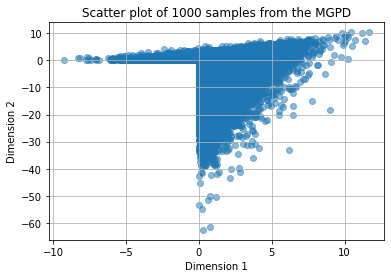

In [3]:
n_samples = 100000
d = 2
a = np.array([1, 5])
beta = np.array([0, 0])
sig = np.array([1.0, 1])
gamma = np.array([0, 0])

samples = sim_revexp_u_mgpd(n_samples, d, a, beta, sig, gamma)

# Visualize the samples
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter plot of 1000 samples from the MGPD')
plt.grid(True)
plt.show()

In [4]:
dim = 2
base_dist = dist.MultivariateNormal(torch.zeros(dim, device=device), torch.eye(dim, device=device))

# Define the number of flow steps
num_flows = 10

# Define the flows
flows = []
for _ in range(num_flows):
    # Define an autoregressive neural network
    arn = AutoRegressiveNN(dim, [64,64]).to(device)
    # Define the affine autoregressive flow
    flow = AffineAutoregressive(arn).to(device)
    flows.append(flow)

# Wrap flows in an nn.ModuleList and define the model
class NormalizingFlowModel(torch.nn.Module):
    def __init__(self, base_dist, transforms):
        super(NormalizingFlowModel, self).__init__()
        self.base_dist = base_dist
        self.transforms = torch.nn.ModuleList(transforms)
        self.transform = ComposeTransform(self.transforms)
        self.flow_dist = dist.TransformedDistribution(self.base_dist, self.transform)
    
    def log_prob(self, x):
        return self.flow_dist.log_prob(x)
    
    def forward(self, x):
        return self.flow_dist.log_prob(x)
    
    def sample(self, sample_shape=torch.Size()):
        return self.flow_dist.sample(sample_shape)



f_T_model = NormalizingFlowModel(base_dist, flows).to(device)

In [5]:
data = torch.tensor(samples, dtype=torch.float, device = device)


In [6]:
torch.cuda.memory_allocated(device) 

1180672

Iteration 0, Loss: 14.98707103729248
Iteration 0 - Learning Rate: 0.0005


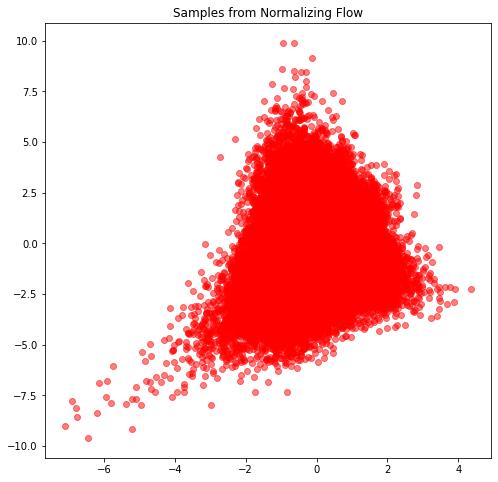

Iteration 1, Loss: 6.736788749694824
Iteration 1 - Learning Rate: 0.0004999996915749259
Iteration 2, Loss: 8.048273086547852
Iteration 2 - Learning Rate: 0.0004999987663004646
Iteration 3, Loss: 5.667969226837158
Iteration 3 - Learning Rate: 0.000499997224178899
Iteration 4, Loss: 4.827922821044922
Iteration 4 - Learning Rate: 0.0004999950652140343
Iteration 5, Loss: 4.2653584480285645
Iteration 5 - Learning Rate: 0.0004999922894111975
Iteration 6, Loss: 4.125973701477051
Iteration 6 - Learning Rate: 0.0004999888967772375
Iteration 7, Loss: 4.146724700927734
Iteration 7 - Learning Rate: 0.0004999848873205254
Iteration 8, Loss: 4.074326038360596
Iteration 8 - Learning Rate: 0.0004999802610509541
Iteration 9, Loss: 3.9893312454223633
Iteration 9 - Learning Rate: 0.0004999750179799384
Iteration 10, Loss: 4.091836929321289
Iteration 10 - Learning Rate: 0.0004999691581204152
Iteration 11, Loss: 3.939671516418457
Iteration 11 - Learning Rate: 0.000499962681486843
Iteration 12, Loss: 3.916926

Iteration 92, Loss: 3.750844955444336
Iteration 92 - Learning Rate: 0.0004973940296506625
Iteration 93, Loss: 3.8487231731414795
Iteration 93 - Learning Rate: 0.0004973371715617683
Iteration 94, Loss: 3.6178293228149414
Iteration 94 - Learning Rate: 0.0004972797031929903
Iteration 95, Loss: 3.744997501373291
Iteration 95 - Learning Rate: 0.000497221624686126
Iteration 96, Loss: 3.8532555103302
Iteration 96 - Learning Rate: 0.0004971629361844783
Iteration 97, Loss: 3.6294822692871094
Iteration 97 - Learning Rate: 0.0004971036378328555
Iteration 98, Loss: 3.835537910461426
Iteration 98 - Learning Rate: 0.00049704372977757
Iteration 99, Loss: 3.8869051933288574
Iteration 99 - Learning Rate: 0.0004969832121664393
Iteration 100, Loss: 3.657217264175415
Iteration 100 - Learning Rate: 0.0004969220851487843


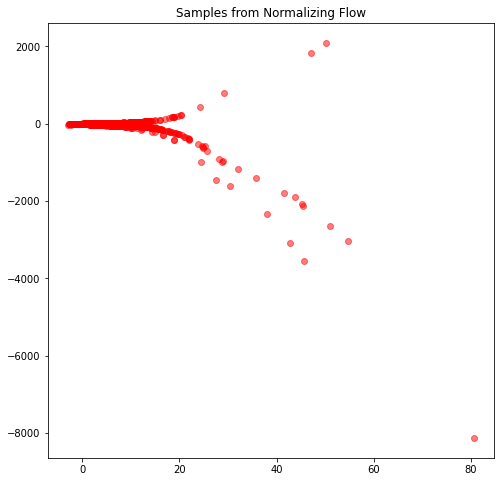

Iteration 101, Loss: 3.813838243484497
Iteration 101 - Learning Rate: 0.0004968603488754301
Iteration 102, Loss: 3.6410112380981445
Iteration 102 - Learning Rate: 0.0004967980034987047
Iteration 103, Loss: 3.967867374420166
Iteration 103 - Learning Rate: 0.0004967350491724391
Iteration 104, Loss: 3.903927803039551
Iteration 104 - Learning Rate: 0.0004966714860519669
Iteration 105, Loss: 3.867009162902832
Iteration 105 - Learning Rate: 0.0004966073142941238
Iteration 106, Loss: 4.089797496795654
Iteration 106 - Learning Rate: 0.0004965425340572471
Iteration 107, Loss: 3.851921558380127
Iteration 107 - Learning Rate: 0.0004964771455011757
Iteration 108, Loss: 3.9134907722473145
Iteration 108 - Learning Rate: 0.0004964111487872494
Iteration 109, Loss: 3.8787076473236084
Iteration 109 - Learning Rate: 0.0004963445440783085
Iteration 110, Loss: 3.9660050868988037
Iteration 110 - Learning Rate: 0.0004962773315386934
Iteration 111, Loss: 3.9186935424804688
Iteration 111 - Learning Rate: 0.000

Iteration 190, Loss: 3.722170352935791
Iteration 190 - Learning Rate: 0.0004889482536995825
Iteration 191, Loss: 3.7703704833984375
Iteration 191 - Learning Rate: 0.0004888324895908349
Iteration 192, Loss: 3.6769585609436035
Iteration 192 - Learning Rate: 0.0004887161361866608
Iteration 193, Loss: 3.6780667304992676
Iteration 193 - Learning Rate: 0.0004885991937741507
Iteration 194, Loss: 3.5676703453063965
Iteration 194 - Learning Rate: 0.0004884816626418485
Iteration 195, Loss: 3.87786865234375
Iteration 195 - Learning Rate: 0.0004883635430797505
Iteration 196, Loss: 3.973085403442383
Iteration 196 - Learning Rate: 0.0004882448353793049
Iteration 197, Loss: 3.774237632751465
Iteration 197 - Learning Rate: 0.00048812553983341116
Iteration 198, Loss: 3.7867238521575928
Iteration 198 - Learning Rate: 0.00048800565673641933
Iteration 199, Loss: 3.8616998195648193
Iteration 199 - Learning Rate: 0.00048788518638412886
Iteration 200, Loss: 3.8228373527526855
Iteration 200 - Learning Rate: 0

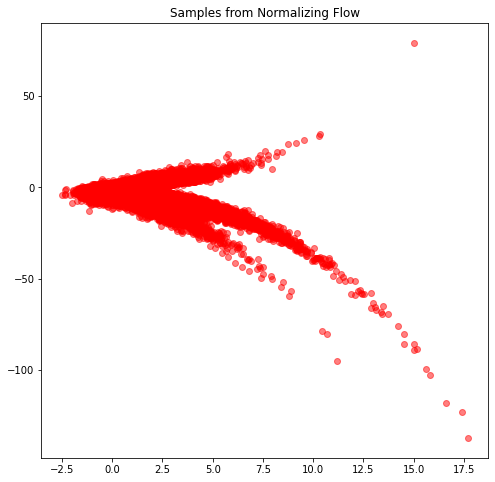

Iteration 201, Loss: 3.897289752960205
Iteration 201 - Learning Rate: 0.0004876424851040952
Iteration 202, Loss: 3.8886258602142334
Iteration 202 - Learning Rate: 0.00048752025477519304
Iteration 203, Loss: 3.788304090499878
Iteration 203 - Learning Rate: 0.0004873974383886736
Iteration 204, Loss: 3.7582356929779053
Iteration 204 - Learning Rate: 0.0004872740362475738
Iteration 205, Loss: 3.847268581390381
Iteration 205 - Learning Rate: 0.0004871500486563763
Iteration 206, Loss: 3.7503175735473633
Iteration 206 - Learning Rate: 0.00048702547592100815
Iteration 207, Loss: 3.8356471061706543
Iteration 207 - Learning Rate: 0.0004869003183488402
Iteration 208, Loss: 3.7522830963134766
Iteration 208 - Learning Rate: 0.00048677457624868623
Iteration 209, Loss: 3.7828593254089355
Iteration 209 - Learning Rate: 0.0004866482499308025
Iteration 210, Loss: 3.8502488136291504
Iteration 210 - Learning Rate: 0.00048652133970688655
Iteration 211, Loss: 3.7847414016723633
Iteration 211 - Learning Rate

Iteration 289, Loss: 3.8793816566467285
Iteration 289 - Learning Rate: 0.000474679380602892
Iteration 290, Loss: 3.804441452026367
Iteration 290 - Learning Rate: 0.000474506893940154
Iteration 291, Loss: 3.849090576171875
Iteration 291 - Learning Rate: 0.0004743338533289729
Iteration 292, Loss: 3.7459402084350586
Iteration 292 - Learning Rate: 0.00047416025919630906
Iteration 293, Loss: 3.721918821334839
Iteration 293 - Learning Rate: 0.00047398611197048873
Iteration 294, Loss: 3.7230899333953857
Iteration 294 - Learning Rate: 0.00047381141208120296
Iteration 295, Loss: 3.864041805267334
Iteration 295 - Learning Rate: 0.0004736361599595063
Iteration 296, Loss: 3.813106060028076
Iteration 296 - Learning Rate: 0.00047346035603781597
Iteration 297, Loss: 3.7902402877807617
Iteration 297 - Learning Rate: 0.00047328400074991064
Iteration 298, Loss: 3.738301992416382
Iteration 298 - Learning Rate: 0.0004731070945309295
Iteration 299, Loss: 3.855363368988037
Iteration 299 - Learning Rate: 0.0

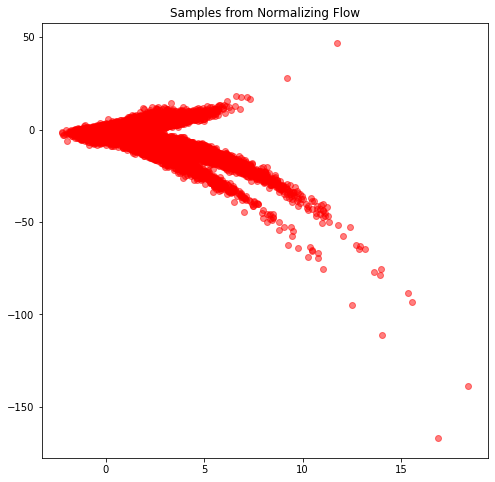

Iteration 301, Loss: 3.7411792278289795
Iteration 301 - Learning Rate: 0.00047257307465930646
Iteration 302, Loss: 3.8606152534484863
Iteration 302 - Learning Rate: 0.00047239396909458457
Iteration 303, Loss: 3.683394432067871
Iteration 303 - Learning Rate: 0.00047221431479485136
Iteration 304, Loss: 3.8101000785827637
Iteration 304 - Learning Rate: 0.0004720341122033862
Iteration 305, Loss: 3.795541763305664
Iteration 305 - Learning Rate: 0.0004718533617648209
Iteration 306, Loss: 3.8600268363952637
Iteration 306 - Learning Rate: 0.00047167206392513924
Iteration 307, Loss: 3.852891445159912
Iteration 307 - Learning Rate: 0.0004714902191316755
Iteration 308, Loss: 3.5634772777557373
Iteration 308 - Learning Rate: 0.0004713078278331139
Iteration 309, Loss: 3.8381738662719727
Iteration 309 - Learning Rate: 0.0004711248904794866
Iteration 310, Loss: 3.811039924621582
Iteration 310 - Learning Rate: 0.00047094140752217345
Iteration 311, Loss: 3.711851119995117
Iteration 311 - Learning Rate:

Iteration 390, Loss: 3.72499418258667
Iteration 390 - Learning Rate: 0.0004545374293562556
Iteration 391, Loss: 3.7911810874938965
Iteration 391 - Learning Rate: 0.00045431137307677726
Iteration 392, Loss: 3.7595324516296387
Iteration 392 - Learning Rate: 0.00045408481267929576
Iteration 393, Loss: 3.876816987991333
Iteration 393 - Learning Rate: 0.00045385774872282647
Iteration 394, Loss: 3.9392881393432617
Iteration 394 - Learning Rate: 0.00045363018176762716
Iteration 395, Loss: 3.761594772338867
Iteration 395 - Learning Rate: 0.0004534021123751966
Iteration 396, Loss: 3.789093494415283
Iteration 396 - Learning Rate: 0.0004531735411082733
Iteration 397, Loss: 3.87274432182312
Iteration 397 - Learning Rate: 0.00045294446853083424
Iteration 398, Loss: 3.789113759994507
Iteration 398 - Learning Rate: 0.0004527148952080932
Iteration 399, Loss: 3.9723517894744873
Iteration 399 - Learning Rate: 0.00045248482170649946
Iteration 400, Loss: 3.7916836738586426
Iteration 400 - Learning Rate: 0

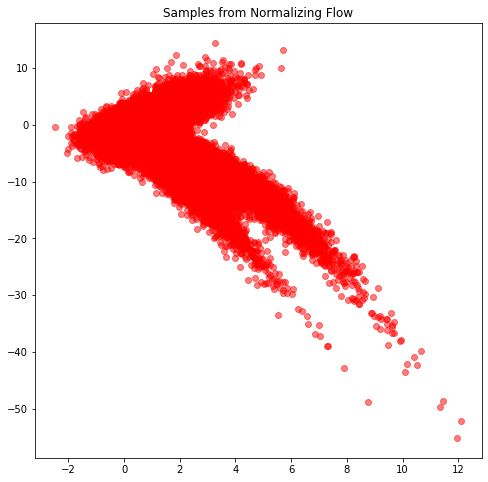

Iteration 401, Loss: 3.68007755279541
Iteration 401 - Learning Rate: 0.00045202317643872097
Iteration 402, Loss: 3.7173590660095215
Iteration 402 - Learning Rate: 0.0004517916058115999
Iteration 403, Loss: 3.814183473587036
Iteration 403 - Learning Rate: 0.00045155953728375105
Iteration 404, Loss: 3.940153121948242
Iteration 404 - Learning Rate: 0.0004513269714277803
Iteration 405, Loss: 3.7165939807891846
Iteration 405 - Learning Rate: 0.0004510939088175209
Iteration 406, Loss: 3.6938107013702393
Iteration 406 - Learning Rate: 0.00045086035002803176
Iteration 407, Loss: 3.7405457496643066
Iteration 407 - Learning Rate: 0.0004506262956355958
Iteration 408, Loss: 3.7057929039001465
Iteration 408 - Learning Rate: 0.00045039174621771904
Iteration 409, Loss: 3.64461088180542
Iteration 409 - Learning Rate: 0.00045015670235312884
Iteration 410, Loss: 3.6604716777801514
Iteration 410 - Learning Rate: 0.0004499211646217726
Iteration 411, Loss: 3.7161307334899902
Iteration 411 - Learning Rate: 

Iteration 490, Loss: 3.8578648567199707
Iteration 490 - Learning Rate: 0.0004295315744407971
Iteration 491, Loss: 3.7586073875427246
Iteration 491 - Learning Rate: 0.00042925806874886
Iteration 492, Loss: 3.797682762145996
Iteration 492 - Learning Rate: 0.00042898412075545765
Iteration 493, Loss: 3.597494602203369
Iteration 493 - Learning Rate: 0.00042870973113652973
Iteration 494, Loss: 3.6963415145874023
Iteration 494 - Learning Rate: 0.0004284349005691052
Iteration 495, Loss: 3.7879092693328857
Iteration 495 - Learning Rate: 0.00042815962973130124
Iteration 496, Loss: 3.8930437564849854
Iteration 496 - Learning Rate: 0.00042788391930232133
Iteration 497, Loss: 3.771674633026123
Iteration 497 - Learning Rate: 0.00042760776996245327
Iteration 498, Loss: 3.8254587650299072
Iteration 498 - Learning Rate: 0.00042733118239306835
Iteration 499, Loss: 3.582343578338623
Iteration 499 - Learning Rate: 0.0004270541572766189
Iteration 500, Loss: 3.6644582748413086
Iteration 500 - Learning Rate:

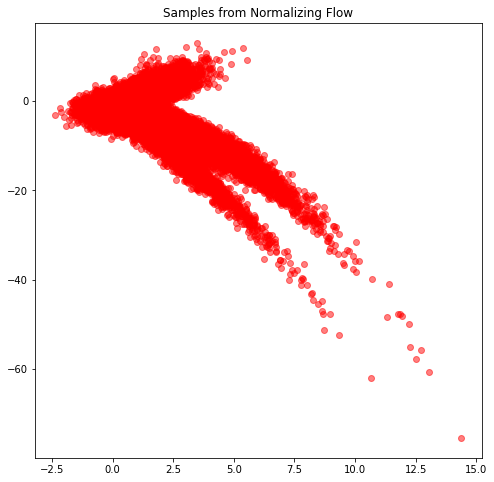

Iteration 501, Loss: 3.816714286804199
Iteration 501 - Learning Rate: 0.00042649879713773183
Iteration 502, Loss: 4.012608528137207
Iteration 502 - Learning Rate: 0.0004262204634855902
Iteration 503, Loss: 3.717073440551758
Iteration 503 - Learning Rate: 0.0004259416950269725
Iteration 504, Loss: 3.894340991973877
Iteration 504 - Learning Rate: 0.00042566249244971213
Iteration 505, Loss: 3.62469744682312
Iteration 505 - Learning Rate: 0.00042538285644271376
Iteration 506, Loss: 3.8343381881713867
Iteration 506 - Learning Rate: 0.00042510278769595134
Iteration 507, Loss: 4.000986099243164
Iteration 507 - Learning Rate: 0.00042482228690046686
Iteration 508, Loss: 4.031018257141113
Iteration 508 - Learning Rate: 0.00042454135474836796
Iteration 509, Loss: 3.700054168701172
Iteration 509 - Learning Rate: 0.00042425999193282686
Iteration 510, Loss: 4.0447258949279785
Iteration 510 - Learning Rate: 0.00042397819914807833
Iteration 511, Loss: 3.732980728149414
Iteration 511 - Learning Rate: 0

Iteration 590, Loss: 3.7249112129211426
Iteration 590 - Learning Rate: 0.00040010505633147095
Iteration 591, Loss: 3.6970481872558594
Iteration 591 - Learning Rate: 0.00039979083584492395
Iteration 592, Loss: 3.913544178009033
Iteration 592 - Learning Rate: 0.0003994762457643797
Iteration 593, Loss: 3.8697872161865234
Iteration 593 - Learning Rate: 0.00039916128686605807
Iteration 594, Loss: 3.752908229827881
Iteration 594 - Learning Rate: 0.0003988459599270887
Iteration 595, Loss: 3.7552273273468018
Iteration 595 - Learning Rate: 0.00039853026572550965
Iteration 596, Loss: 3.856842041015625
Iteration 596 - Learning Rate: 0.00039821420504026486
Iteration 597, Loss: 3.8217625617980957
Iteration 597 - Learning Rate: 0.0003978977786512026
Iteration 598, Loss: 3.9249839782714844
Iteration 598 - Learning Rate: 0.0003975809873390737
Iteration 599, Loss: 3.877786636352539
Iteration 599 - Learning Rate: 0.000397263831885529
Iteration 600, Loss: 3.7388768196105957
Iteration 600 - Learning Rate:

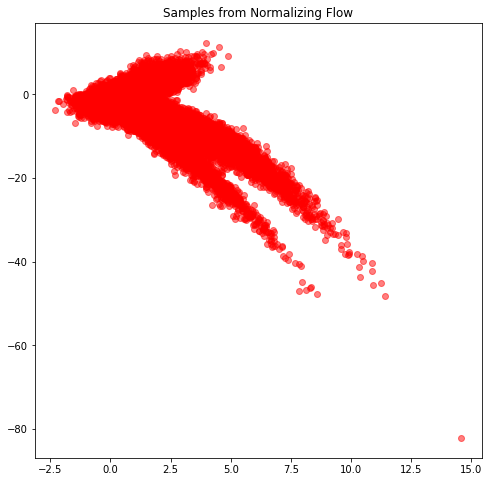

Iteration 601, Loss: 3.7591915130615234
Iteration 601 - Learning Rate: 0.0003966284316852876
Iteration 602, Loss: 3.7944297790527344
Iteration 602 - Learning Rate: 0.0003963101885063776
Iteration 603, Loss: 3.762794256210327
Iteration 603 - Learning Rate: 0.0003959915843216217
Iteration 604, Loss: 3.7152085304260254
Iteration 604 - Learning Rate: 0.0003956726199171441
Iteration 605, Loss: 3.800595283508301
Iteration 605 - Learning Rate: 0.00039535329607995773
Iteration 606, Loss: 3.9258930683135986
Iteration 606 - Learning Rate: 0.00039503361359796246
Iteration 607, Loss: 3.7578890323638916
Iteration 607 - Learning Rate: 0.0003947135732599429
Iteration 608, Loss: 3.753788471221924
Iteration 608 - Learning Rate: 0.00039439317585556697
Iteration 609, Loss: 3.812378168106079
Iteration 609 - Learning Rate: 0.0003940724221753833
Iteration 610, Loss: 3.6809000968933105
Iteration 610 - Learning Rate: 0.00039375131301081976
Iteration 611, Loss: 3.745151996612549
Iteration 611 - Learning Rate: 

Iteration 690, Loss: 3.788576126098633
Iteration 690 - Learning Rate: 0.00036698245356514336
Iteration 691, Loss: 3.8908133506774902
Iteration 691 - Learning Rate: 0.0003666352554352032
Iteration 692, Loss: 3.822849750518799
Iteration 692 - Learning Rate: 0.0003662877695193646
Iteration 693, Loss: 3.9909121990203857
Iteration 693 - Learning Rate: 0.00036593999667501457
Iteration 694, Loss: 3.6830062866210938
Iteration 694 - Learning Rate: 0.00036559193776024784
Iteration 695, Loss: 3.900728225708008
Iteration 695 - Learning Rate: 0.00036524359363386555
Iteration 696, Loss: 3.864109516143799
Iteration 696 - Learning Rate: 0.00036489496515537196
Iteration 697, Loss: 3.7088985443115234
Iteration 697 - Learning Rate: 0.0003645460531849731
Iteration 698, Loss: 3.737194061279297
Iteration 698 - Learning Rate: 0.00036419685858357485
Iteration 699, Loss: 3.768439292907715
Iteration 699 - Learning Rate: 0.00036384738221278
Iteration 700, Loss: 3.730585813522339
Iteration 700 - Learning Rate: 0.

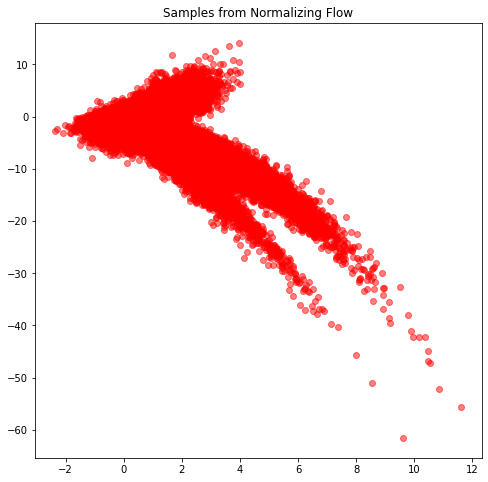

Iteration 701, Loss: 3.746420383453369
Iteration 701 - Learning Rate: 0.0003631475876128863
Iteration 702, Loss: 3.832768678665161
Iteration 702 - Learning Rate: 0.00036279727111046127
Iteration 703, Loss: 3.7211432456970215
Iteration 703 - Learning Rate: 0.00036244667629198253
Iteration 704, Loss: 3.799764394760132
Iteration 704 - Learning Rate: 0.00036209580402250807
Iteration 705, Loss: 3.79380464553833
Iteration 705 - Learning Rate: 0.00036174465516778027
Iteration 706, Loss: 3.6657347679138184
Iteration 706 - Learning Rate: 0.00036139323059422405
Iteration 707, Loss: 3.8604202270507812
Iteration 707 - Learning Rate: 0.00036104153116894465
Iteration 708, Loss: 3.6807518005371094
Iteration 708 - Learning Rate: 0.00036068955775972537
Iteration 709, Loss: 3.865391492843628
Iteration 709 - Learning Rate: 0.00036033731123502567
Iteration 710, Loss: 3.7516379356384277
Iteration 710 - Learning Rate: 0.0003599847924639788
Iteration 711, Loss: 3.8044111728668213
Iteration 711 - Learning Rat

KeyboardInterrupt: 

In [7]:
optimizer = torch.optim.Adam(f_T_model.parameters(), lr=5e-4,weight_decay=1e-5)
batch_size = 256
num_iterations = 2000
loss_history = []
show_iter = 100

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_iterations)

# Integration settings
s_min = -10.0
s_max = 10.0
num_integration_points = 10000
s_values = torch.linspace(s_min, s_max, num_integration_points, device=device)
s_values = s_values.reshape(-1, 1, 1)

for it in range(num_iterations):
    # Sample a batch of data from h_U
    idx = np.random.choice(data.shape[0], batch_size, replace=False)
    batch_x = data[idx]  # Shape (batch_size, dim)
    
    # Expand batch_x to match s_values
    x_expanded = batch_x.unsqueeze(0)  # Shape (1, effective_batch_size, dim)
    x_expanded = x_expanded.expand(num_integration_points, -1, -1)  # Shape (num_points, effective_batch_size, dim)
    
    # Expand s_values to match batch size and dimension
    s_expanded = s_values.to(batch_x.device)  # Shape (num_points, 1, 1)

    s_expanded = s_expanded.expand(-1, batch_size, 1)  # Shape (num_points, effective_batch_size, 1)

    # Compute x + s for all s_values
    x_plus_s = x_expanded + s_expanded  # Broadcasting over the last dimension
    # x_plus_s shape: (num_points, effective_batch_size, dim)
    x_plus_s = x_plus_s.reshape(-1, dim)  # Flatten to (num_points * effective_batch_size, dim)

    # Compute f_U(x + s)
    log_f_T = f_T_model.log_prob(x_plus_s)  # Shape (num_points * effective_batch_size,)
    
    # Corrected reshaping using the effective batch size
#     f_U_x_s = torch.exp(log_f_U).reshape(num_integration_points, batch_size)  # Shape (num_points, effective_batch_size)
    
    #####################################################################################
#     # Compute the integrand f_U(x + s) * exp(s)
#     exp_s = torch.exp(s_values.squeeze(-1)).to(batch_x.device)  # Shape (num_points, 1)
#     integrand = f_U_x_s * exp_s  # Broadcasting over effective_batch_size
    
#     # Compute the integral using the trapezoidal rule
#     delta_s = (s_max - s_min) / (num_integration_points - 1)
#     integral = torch.trapz(integrand, dx=delta_s, dim=0)  # Shape (effective_batch_size,)
    #######################################################################################
    # log_integrand.shape = (num_points, batch_size)
    # Each element is [log f_U(x+s) + s]
    log_integrand = log_f_T.reshape(num_integration_points, batch_size)
    # We want to numerically approximate log( ∫ exp(log_integrand) ds ).
    # The trapezoid rule in log-space can be approximated by log-sum-exp:

    # 1. log-sum-exp over 'num_points' dimension
    max_vals, _ = torch.max(log_integrand, dim=0, keepdim=True)  # shape (1, batch_size)
    stable_exp = torch.exp(log_integrand - max_vals)             # shape (num_points, batch_size)
    delta_s = (s_max - s_min) / (num_integration_points - 1)
    sum_exp = torch.trapz(stable_exp, dx=delta_s, dim=0)         # shape (batch_size,)
    # 2. Now put the max_vals back in:
    log_integral = max_vals.squeeze(0) + torch.log(sum_exp + 1e-40)  # shape (batch_size,)
#     print(log_integral.shape)
    ########################################################################################

    max_U = torch.max(batch_x, dim=1)[0]
    
    ########################################################################################
#     # Compute h_U(x)
#     h_U_x = (1 / E_exp_max_U) * integral
    
#     # Avoid log of zero
#     h_U_x = torch.clamp(h_U_x, min=1e-12)
#     # Compute the negative log-likelihood loss
#     loss = -torch.log(h_U_x)
    ########################################################################################
    loss = -log_integral + max_U
    
    ########################################################################################


    batch_loss = loss.mean()
    
    # Backpropagation
    optimizer.zero_grad()
    batch_loss.backward()
    
    optimizer.step()
    
    # Record loss
    loss_history.append(batch_loss.item())
    
    if it % 1 == 0:
        print(f"Iteration {it}, Loss: {batch_loss.item()}")
        current_lr = optimizer.param_groups[0]['lr']
    
        print(f"Iteration {it} - Learning Rate: {current_lr}")
        # Debugging: Print shapes
    if it % show_iter == 0:
        samples = f_T_model.sample((n_samples,))

        plt.figure(figsize=(8,8))
        plt.scatter(samples[:,0].cpu().numpy(), samples[:,1].cpu().numpy(), alpha=0.5, color='red')
        plt.title('Samples from Normalizing Flow')
        plt.show()

    scheduler.step()
    
# Plot the training loss
plt.figure()
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [ ]:
with torch.no_grad():
    samples = f_T_model.sample((n_samples,))

# Plot the samples from the flow
plt.figure(figsize=(8,8))
plt.scatter(samples[:,0].numpy(), samples[:,1].numpy(), alpha=0.5, color='red')
plt.title('Samples from Normalizing Flow')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

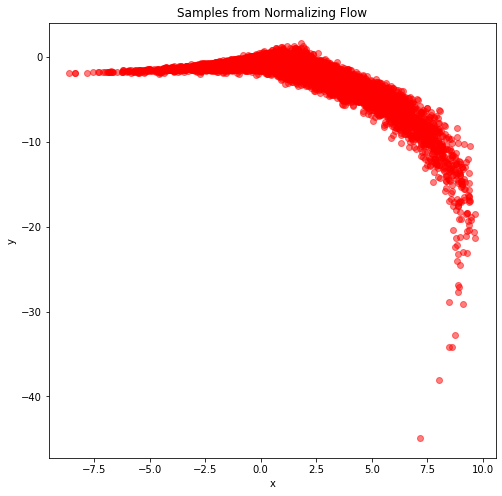

In [16]:
with torch.no_grad():
    samples_f_T = f_T_model.sample((n_samples,))

# Plot the samples from the flow
plt.figure(figsize=(8,8))
plt.scatter(samples_f_T[:,0].cpu().numpy(), samples_f_T[:,1].cpu().numpy(), alpha=0.5, color='red')
plt.title('Samples from Normalizing Flow')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
with torch.no_grad():
    samples = f_T_model.sample((n_samples,))

# Plot the samples from the flow
plt.figure(figsize=(8,8))
plt.scatter(samples[:,0].numpy(), samples[:,1].numpy(), alpha=0.5, color='red')
plt.title('Samples from Normalizing Flow')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [17]:
T = samples_f_T
T_max = torch.max(samples_f_T,axis=1,keepdim=True)[0]
T1 = T-T_max
E = torch.empty(n_samples,device=device)
E = E.exponential_(1.0).unsqueeze(1)
Pred = E + T1

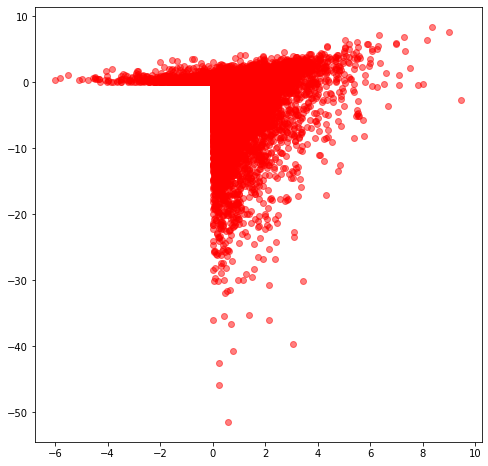

In [18]:
plt.figure(figsize=(8,8))
plt.scatter(Pred[:,0].cpu().numpy(), Pred[:,1].cpu().numpy(), alpha=0.5, color='red')

/tmp/ipykernel_3270442/1346766279.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples[:,0].cpu().numpy(), hist=False, kde=True,
/tmp/ipykernel_3270442/1346766279.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Pred[:,0].cpu().numpy(), hist=False, kde=True,
/tmp/ipyk

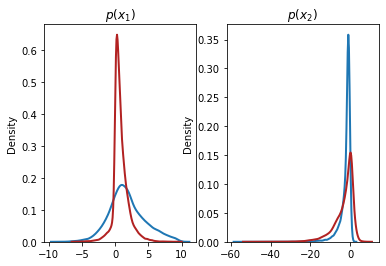

In [19]:
plt.subplot(1, 2, 1)
sns.distplot(samples[:,0].cpu().numpy(), hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(Pred[:,0].cpu().numpy(), hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(samples[:,1].cpu().numpy(), hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(Pred[:,1].cpu().numpy(), hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()
